In [152]:
import numpy as np
import matplotlib.pyplot as plt
from time import gmtime, strftime
import scipy.io as sio
from scipy.signal import butter
from scipy.signal import lfilter


LOG_DIR = "/content/drive/MyDrive/QRS_detector/logs"
PLOT_DIR = "/content/drive/MyDrive/QRS_detector/plots"


class QRSDetector(object):

    def __init__(self, ecg_data_path, verbose=False, log_data=False, plot_data=False, show_plot=False):

        # Configuration parameters.
        self.ecg_data_path = ecg_data_path

        self.signal_frequency = 400  # ECG frequency in samples per second .

        self.filter_lowcut = 0.5
        self.filter_highcut = 60.0
        self.filter_order = 1

        self.integration_window = 15  # Change proportionally when adjusting frequency.

        self.findpeaks_limit = 0.5
        self.findpeaks_spacing = 10  # Change proportionally when adjusting frequency.

        self.refractory_period = 120  # Change proportionally when adjusting frequency.
        self.qrs_peak_filtering_factor = 0.125
        self.noise_peak_filtering_factor = 0.125
        self.qrs_noise_diff_weight = 0.25

        # Loaded ECG data.
        self.ecg_data_raw = None

        # Measured and calculated values.
        self.filtered_ecg_measurements = None
        self.differentiated_ecg_measurements = None
        self.squared_ecg_measurements = None
        self.detected_peaks_indices = None
        self.detected_peaks_values = None

        self.qrs_peak_value = 0.0
        self.noise_peak_value = 0.0
        self.threshold_value = 0.0

        # Detection results.
        self.qrs_peaks_indices = np.array([], dtype=int)
        self.noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        self.ecg_data_detected = None

        # Run whole detector flow.
        self.load_ecg_data()
        self.detect_peaks()
        self.detect_qrs()

        if verbose:
            self.print_detection_data()

        if log_data:
            self.log_path = "{:s}QRS_offline_detector_log_{:s}.csv".format(LOG_DIR, strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.log_detection_data()

        if plot_data:
            self.plot_path = "{:s}QRS_offline_detector_plot_{:s}.png".format(PLOT_DIR, strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.plot_detection_data(show_plot=show_plot)

        #Loading ECG measurements data methods

    def load_ecg_data(self):
        
        #Method loading ECG data set from google drive file.
        
        self.ecg_data_raw = np.loadtxt(self.ecg_data_path, skiprows=1, delimiter=',')

       #ECG measurements data processing.
    
    #Method for extracting peaks from ECG measurements data through measurements processing.
    def detect_peaks(self): 
        # Extract measurements from loaded ECG data.
        ecg_measurements = self.ecg_data_raw[:, 1]

        # Measurements filtering - 0-20 Hz band pass filter.
        self.filtered_ecg_measurements = self.bandpass_filter(ecg_measurements, lowcut=self.filter_lowcut, highcut=self.filter_highcut, signal_freq=self.signal_frequency, filter_order=self.filter_order)                                                                                                                          
        self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
        self.differentiated_ecg_measurements = np.ediff1d(self.filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
        self.squared_ecg_measurements = self.differentiated_ecg_measurements ** 2

        # Moving-window integration.
        self.integrated_ecg_measurements = np.convolve(self.squared_ecg_measurements, np.ones(self.integration_window), mode='full')

        # Fiducial mark - peak detection on integrated measurements.
        self.detected_peaks_indices = self.findpeaks(data=self.integrated_ecg_measurements, limit=self.findpeaks_limit, spacing=self.findpeaks_spacing)                                                                                                          
        self.detected_peaks_values = self.integrated_ecg_measurements[self.detected_peaks_indices]

       #QRS detection methods.

    def detect_qrs(self):
        
        #Method responsible for classifying detected ECG measurements peaks.
        
        for detected_peak_index, detected_peaks_value in zip(self.detected_peaks_indices, self.detected_peaks_values):

            try:
                last_qrs_index = self.qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > self.refractory_period or not self.qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > self.threshold_value:
                    self.qrs_peaks_indices = np.append(self.qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    self.qrs_peak_value = self.qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - self.qrs_peak_filtering_factor) * self.qrs_peak_value
                else:
                    self.noise_peaks_indices = np.append(self.noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    self.noise_peak_value = self.noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - self.noise_peak_filtering_factor) * self.noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                self.threshold_value = self.noise_peak_value + \
                                       self.qrs_noise_diff_weight * (self.qrs_peak_value - self.noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(self.ecg_data_raw[:, 1]), 1])
        measurement_qrs_detection_flag[self.qrs_peaks_indices] = 1
        self.ecg_data_detected = np.append(self.ecg_data_raw, measurement_qrs_detection_flag, 1)

       #Results reporting methods.
       #Printing the results.

    def print_detection_data(self):
        
        
        
        print("qrs peaks indices:")
        print(self.qrs_peaks_indices)
        print("noise peaks indices:")
        print(self.noise_peaks_indices)
    
    #Logging measured ECG and detection results to a file
    def log_detection_data(self):

        with open(self.log_path, "wb") as fin:
            fin.write(b"timestamp,ecg_measurement,qrs_detected\n")
            np.savetxt(fin, self.ecg_data_detected, delimiter=",")


    #Plotting detection results
    #:param bool show_plot: flag for plotting the results and showing plot
    def plot_detection_data(self, show_plot=False):
        def plot_data(axis, data, title='', fontsize=16):
            axis.set_title(title, fontsize=fontsize)
            axis.grid(which='both', axis='both', linestyle='--')
            axis.plot(data, color="green", zorder=5)

        def plot_points(axis, values, indices):
            axis.scatter(x=indices, y=values[indices], c="red", s=50, zorder=5)

        plt.close('all')
        fig, axarr = plt.subplots(5, sharex=True, figsize=(15, 20))

        plot_data(axis=axarr[0], data=self.ecg_data_raw[:, 1], title='Raw ECG measurements')
        plot_data(axis=axarr[1], data=self.filtered_ecg_measurements, title='Filtered ECG measurements')
        plot_data(axis=axarr[2], data=self.differentiated_ecg_measurements, title='Differentiated ECG measurements')
        plot_data(axis=axarr[3], data=self.squared_ecg_measurements, title='Squared ECG measurements')
        #plot_data(axis=axarr[4], data=self.integrated_ecg_measurements, title='Integrated ECG measurements with QRS peaks marked (red)')
        #plot_points(axis=axarr[4], values=self.integrated_ecg_measurements, indices=self.qrs_peaks_indices)
        plot_data(axis=axarr[4], data=self.ecg_data_detected[:, 1], title='Raw ECG measurements with QRS peaks')
        plot_points(axis=axarr[4], values=self.ecg_data_detected[:, 1], indices=self.qrs_peaks_indices)

        plt.tight_layout()
        fig.savefig(self.plot_path)

        if show_plot:
            plt.show()

        plt.close()



    def bandpass_filter(self, data, lowcut, highcut, signal_freq, filter_order):

        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band", analog=False)
        y = lfilter(b, a, data)
        return y

    #Peaks finding trough the ECG data
    def findpeaks(self, data, spacing=1, limit=None):

        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            # before
            h_b = x[start: start + len]  
            start = spacing
            # central
            h_c = x[start: start + len]  
            start = spacing + s + 1
            # after
            h_a = x[start: start + len]  
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind1 = np.argwhere(peak_candidate)
        ind2 = ind1.reshape(ind1.size)
        if limit is not None:
            ind = ind2[data[ind2] > limit]
        return ind2


__name__ = "__main__"


qrs peaks indices:
[  66  193  389  579  767  954 1141 1328 1514 1700 1885 2068 2251 2433
 2615]
noise peaks indices:
[ 360  550  927 1112 1300 1486 1670 1858 2037 2221 2405 2584]


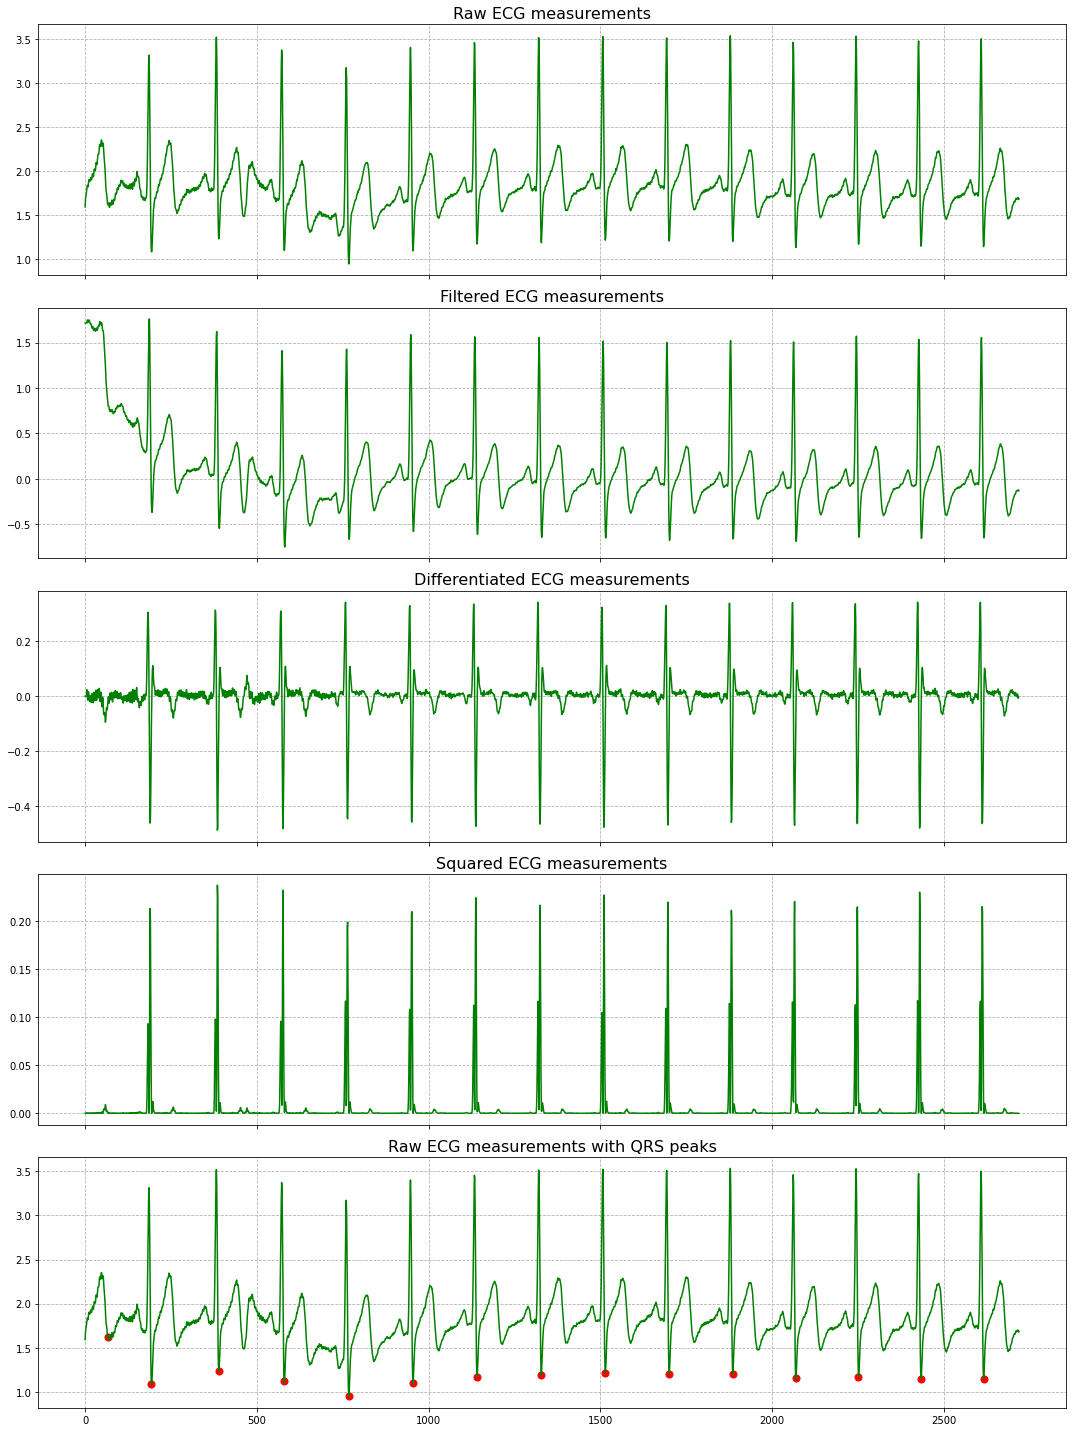

In [153]:
qrs_detector = QRSDetector(ecg_data_path="/content/drive/MyDrive/QRS_detector/ecg_data_1.csv", verbose=True, log_data=True, plot_data=True, show_plot=True)                                  

qrs peaks indices:
[ 24 156 281 482 681 873]
noise peaks indices:
[423 456 612 638 805 824 846]


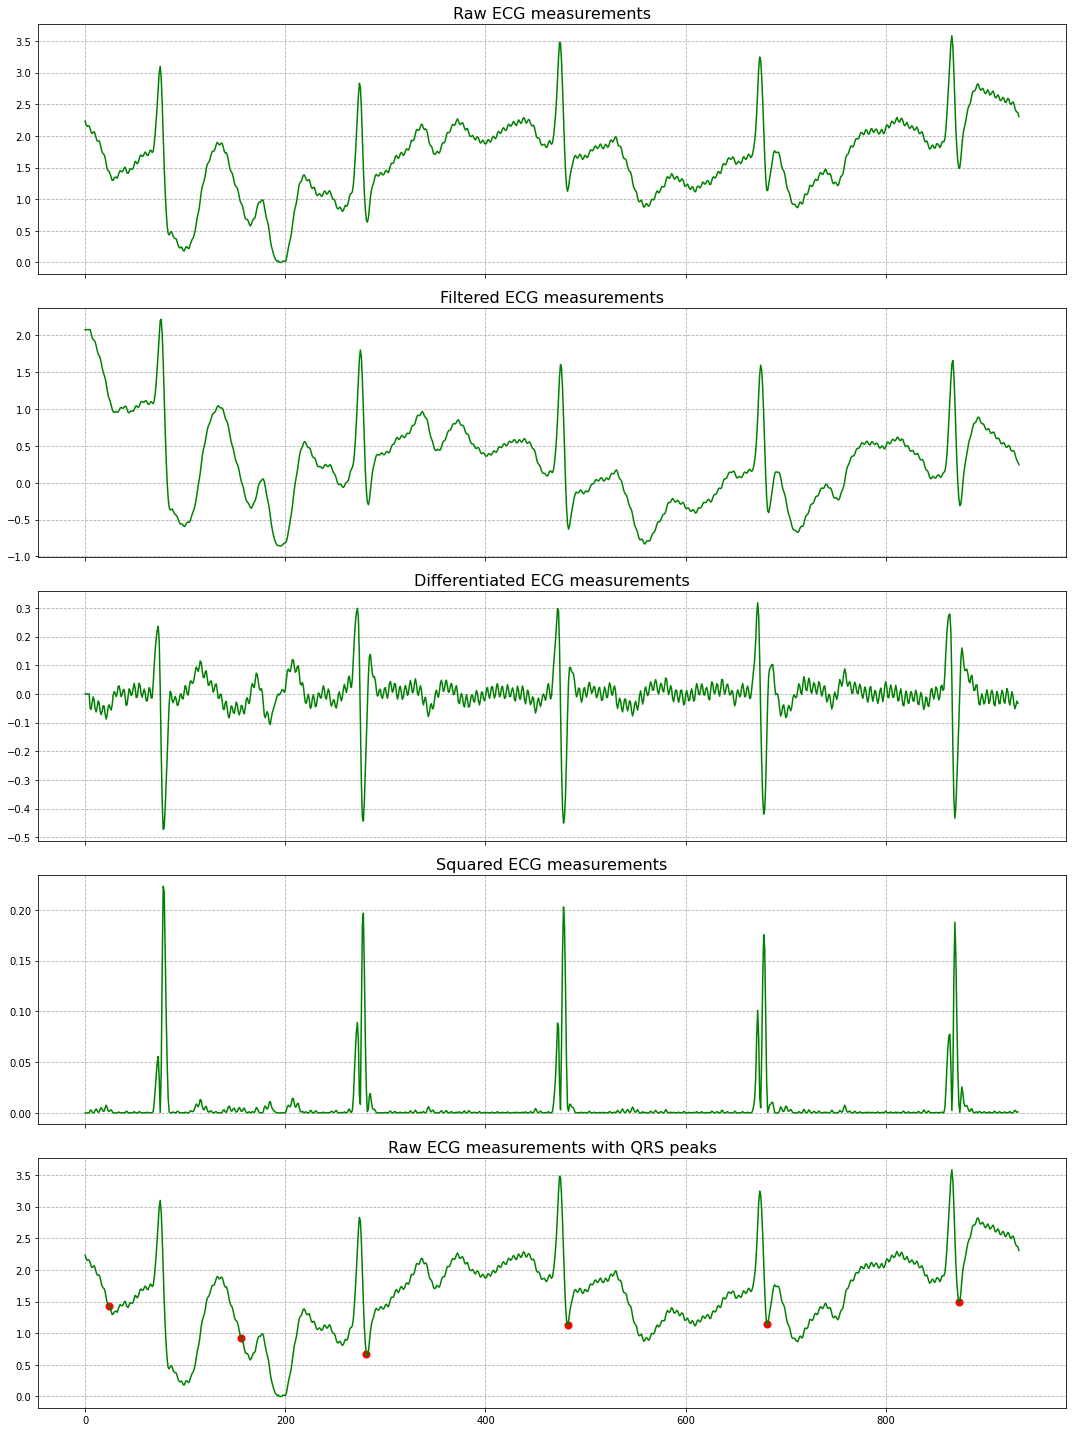

In [154]:
qrs_detector = QRSDetector(ecg_data_path="/content/drive/MyDrive/QRS_detector/ecg_data_2.csv", verbose=True, log_data=True, plot_data=True, show_plot=True)                                 